### Clustering for Shape Image Data (Square and Circle) from 3 Different Frequencies 

In [115]:
from ReadData import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score


Read in the square and circle images 

In [2]:
def readData(path, getTargetName = False):
    # print(getTargetName)
    data = getEMData(path)
    target = []
    field = []
    freq = []
    if getTargetName:
        targetName = []
        upper_case = [char for char in path if char.isupper()]
        target_name = path[path.index(upper_case[0]):path.index(upper_case[1])]

    for i in range(0, len(data)):
        target.append(data[i].target)
        field.append(data[i].Esct.real)
        freq.append(data[i].freq)
        if getTargetName: targetName.append(target_name)

    field = np.array(field)
    target = np.array(target)
    freq = np.array(freq)
    if getTargetName: targetName = np.array(targetName)

    result = (field, target, freq)
    if getTargetName: result = (field, target, freq, targetName)
    return result

In [3]:
fieldCirc, targetCirc, freqCirc, shapeCirc = readData(path = "./CircDifFreq/", getTargetName=True)

Read 310 samples


In [4]:
fieldSqr, targetSqr, freqSqr, shapeSqr = readData("./SqrDifFreq/", True)

Read 390 samples


In [5]:
np.unique(shapeCirc)
# shapeCirc[1]

array(['Circ'], dtype='<U4')

In [6]:
[fieldCirc.shape, fieldSqr.shape]

[(240, 24, 24), (240, 24, 24)]

In [7]:
[targetCirc.shape, targetSqr.shape]

[(240, 50, 50), (240, 50, 50)]

Combine the field image, target image and frequency of theses 2 shapes 

In [5]:
fieldCS = np.concatenate((fieldCirc, fieldSqr))
targetCS = np.concatenate((targetCirc, targetSqr))
freqCS = np.concatenate((freqCirc, freqSqr))
shapeCS = np.concatenate((shapeCirc,shapeSqr))

In [32]:
fieldCS.shape

(700, 24, 24)

In [151]:
fieldCS = fieldCS.reshape(len(fieldCS),-1)
fieldCS.shape

(700, 576)

Create MiniBatchKMeans model

In [104]:
kmeans3 = MiniBatchKMeans(n_clusters = 3, random_state = 420, batch_size=50, max_iter=100)
kmeans2 = MiniBatchKMeans(n_clusters = 2, random_state = 420, batch_size=50, max_iter=100)

Try with 3 clusters corresponding to 3 frequencies to see if clustering groups by frequency

In [108]:
centroids3 = kmeans3.fit(fieldCS).cluster_centers_.reshape(3,24,24)
centroids3.shape

(3, 24, 24)

Plot the centroids for the clusters

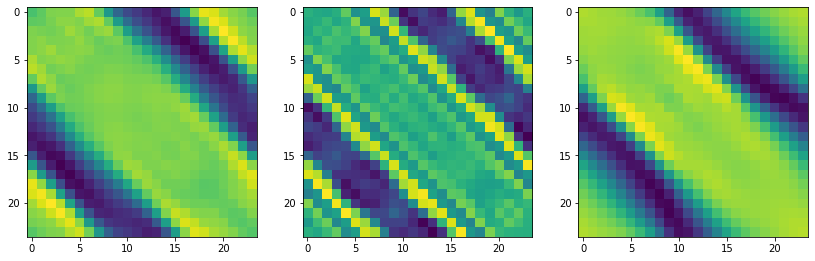

In [92]:
plt.figure(figsize = (14,14))
for index, img in enumerate(centroids3):
    plt.subplot(1,len(centroids3),index+1)
    plt.imshow(img)
    # plt.axis('off')

In [93]:
def getClusters(KMeans, field, freq, target, shape, printFreq = False, printAvgFreq = False, targetShape = False, printShape = False):
    clustered_images = {}
    clustered_freq = {}
    clustered_target = {}
    clustered_shape = {}
    labels = KMeans.labels_
    for i, label in enumerate(labels):
        if label not in clustered_images:
            clustered_images[label] = []
            clustered_freq[label] = []
            clustered_target[label] = []
            if targetShape: clustered_shape[label] = []
        clustered_images[label].append(field[i].reshape(24,24,))  # Add the image to the corresponding cluster
        clustered_freq[label].append(freq[i])
        clustered_target[label].append(target[i])
        if targetShape: clustered_shape[label].append(shape[i])
     
    if printFreq:
        for i in range(0, len(clustered_images)):
            s = 'Cluster ' + str(i) + ' has ' + str(len(clustered_images[i])) + ' images'
            if printAvgFreq:
                s += ', frequency average = ' + str(pd.Series(clustered_freq[i]).mean()) 
            if printFreq:
                s += ', frequency = ' + str(pd.Series(clustered_freq[i]).sort_values().drop_duplicates().tolist())               
            print(s)

    if printShape: 
        for i in range(0, len(clustered_images)):
            s1 = 'Cluster ' + str(i) + ' has shape(s)' + str(pd.Series(clustered_shape[i]).sort_values().drop_duplicates().tolist())    
            print(s1)

    result = (clustered_images, clustered_freq, clustered_target)
    if targetShape: result = (clustered_images, clustered_freq, clustered_target, clustered_shape)
          
    return result

In [94]:
cluster3_img, cluster3_freq, cluster3_target, cluster3_shape = getClusters(kmeans3, fieldCS, freqCS, targetCS, 
                                                                           shapeCS, True, False, True, True)

Cluster 0 has 305 images, frequency = [1000000000.0, 2000000000.0]
Cluster 1 has 170 images, frequency = [3000000000.0]
Cluster 2 has 225 images, frequency = [1000000000.0, 2000000000.0]
Cluster 0 has shape(s)['Circ', 'Sqr']
Cluster 1 has shape(s)['Circ', 'Sqr']
Cluster 2 has shape(s)['Circ', 'Sqr']


In [95]:
def percent_summary(cluster_num, clust_freq, clust_shape, sf = False, freq = False, shape = False):
    print("Cluster: " + str(cluster_num))
    data = {"freq": pd.Series(clust_freq[cluster_num]),
        "shape": pd.Series(clust_shape[cluster_num]),
    }
    df = pd.concat(data,axis = 1)
    df_sf = df.groupby(['shape', 'freq']).size().reset_index(name='Count')
    total_rows = len(df)
    df_sf['Percentage'] = (df_sf['Count'] / total_rows) * 100

    if sf: print(df_sf)


    df_f = df.groupby(['freq']).size().reset_index(name='Count')
    df_f['Percentage'] = (df_f['Count'] / total_rows) * 100
    if freq: print(df_f)


    df_s = df.groupby(['shape']).size().reset_index(name='Count')
    df_s['Percentage'] = (df_s['Count'] / total_rows) * 100
    if shape: print(df_s)


In [96]:
percent_summary(0, cluster3_freq, cluster3_shape, True, True, True)

Cluster: 0
  shape          freq  Count  Percentage
0  Circ  1.000000e+09    117   38.360656
1  Circ  2.000000e+09     63   20.655738
2   Sqr  1.000000e+09     38   12.459016
3   Sqr  2.000000e+09     87   28.524590
           freq  Count  Percentage
0  1.000000e+09    155   50.819672
1  2.000000e+09    150   49.180328
  shape  Count  Percentage
0  Circ    180   59.016393
1   Sqr    125   40.983607


In [97]:
percent_summary(1, cluster3_freq, cluster3_shape, True, True, True)

Cluster: 1
  shape          freq  Count  Percentage
0  Circ  3.000000e+09     80   47.058824
1   Sqr  3.000000e+09     90   52.941176
           freq  Count  Percentage
0  3.000000e+09    170       100.0
  shape  Count  Percentage
0  Circ     80   47.058824
1   Sqr     90   52.941176


In [98]:
percent_summary(2, cluster3_freq, cluster3_shape, True, True, True)

Cluster: 2
  shape          freq  Count  Percentage
0  Circ  1.000000e+09     13    5.777778
1  Circ  2.000000e+09     37   16.444444
2   Sqr  1.000000e+09    132   58.666667
3   Sqr  2.000000e+09     43   19.111111
           freq  Count  Percentage
0  1.000000e+09    145   64.444444
1  2.000000e+09     80   35.555556
  shape  Count  Percentage
0  Circ     50   22.222222
1   Sqr    175   77.777778


Cluster 1 only has images with frequency 3 when the train dataset has smaller size

In [99]:
def view_img(images, row, col, size, numImg):
    plt.figure(figsize = (size,size))
    # gets the list of filenames for a cluster
    if len(images) > numImg:
        images = images[:numImg]
    # plot each image in the cluster
    for index, img in enumerate(images):
        plt.subplot(row,col,index+1)
        plt.imshow(img)

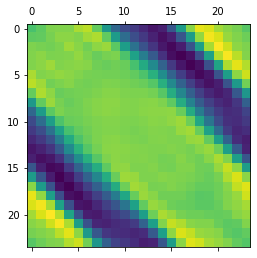

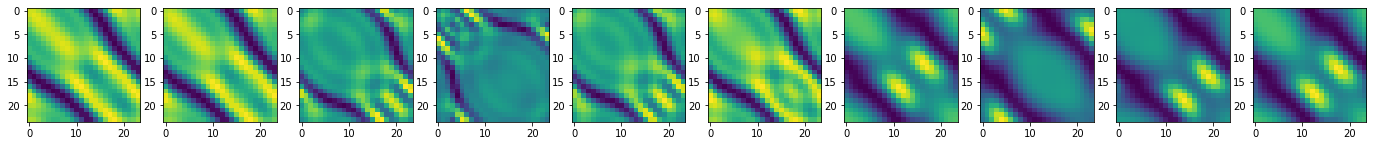

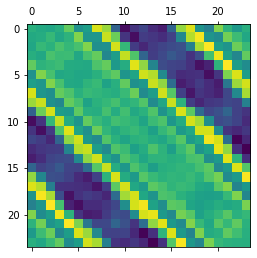

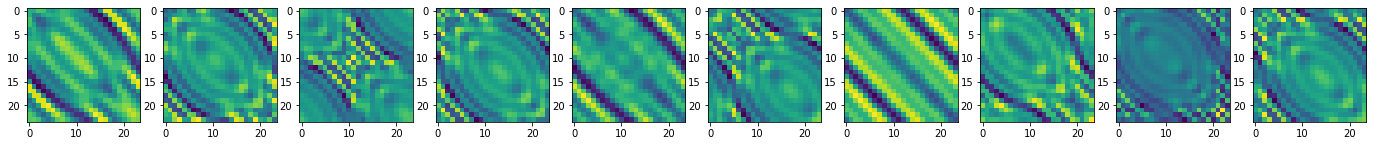

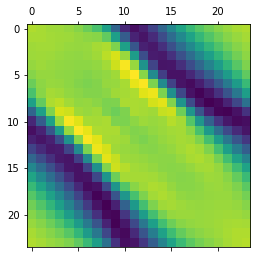

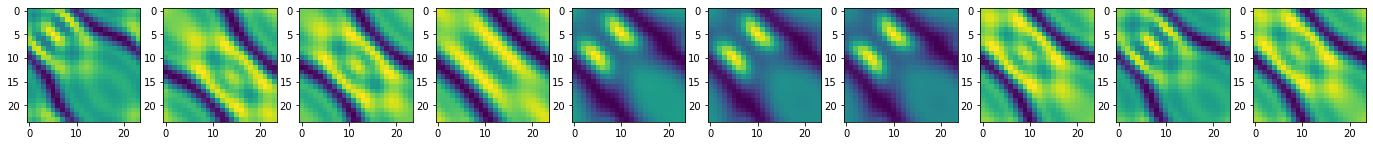

In [100]:
for i in range(0, len(cluster3_img)):   
    plt.matshow(centroids3[i])
    view_img(images = cluster3_img[i], row = 1, col = 10, size = 24,numImg=10)

View target image

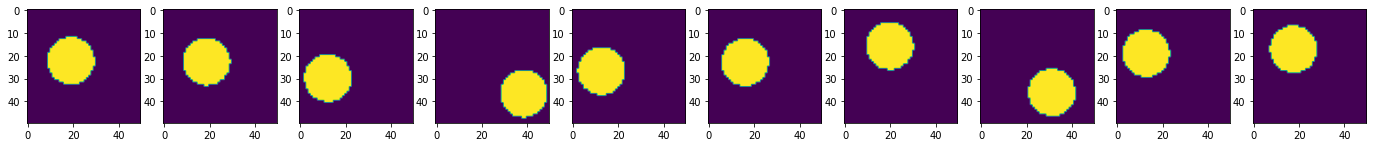

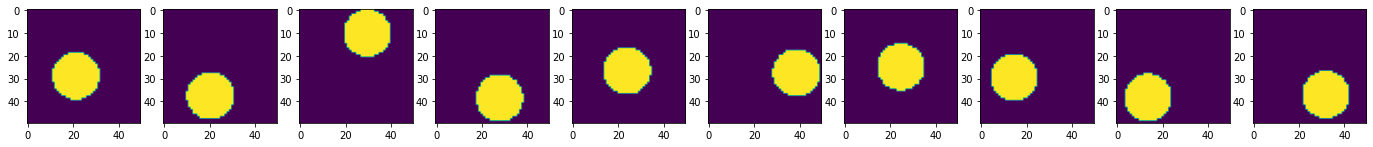

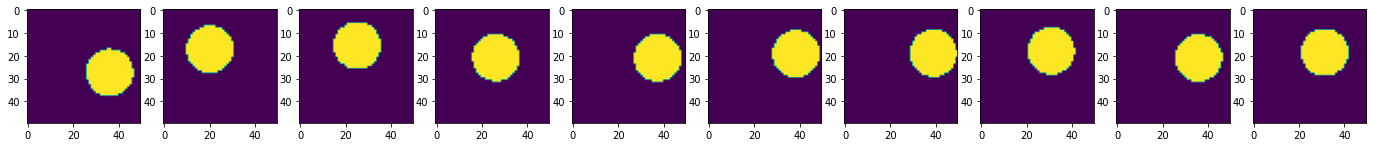

In [101]:
for i in range(0, len(cluster3_target)):   
    view_img(images=cluster3_target[i],row=1,col=10,size=24,numImg=10)

Try with 2 clusters corresponds to the 2 shapes

In [109]:
centroids2 = kmeans2.fit(fieldCS).cluster_centers_.reshape(2,24,24)
centroids2.shape

(2, 24, 24)

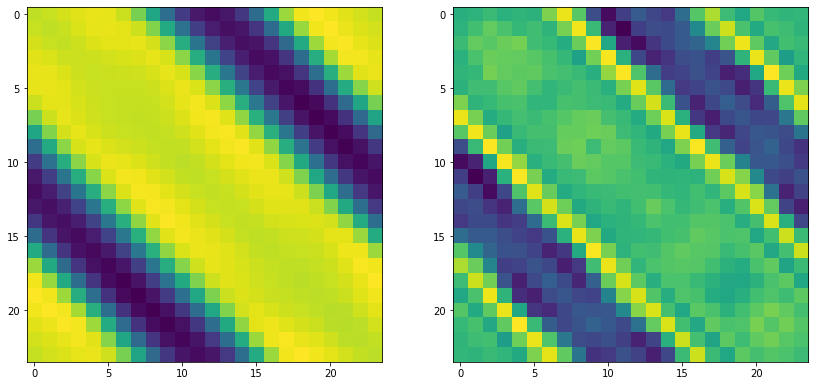

In [110]:
plt.figure(figsize = (14,14))
for index, img in enumerate(centroids2):
    plt.subplot(1,len(centroids2),index+1)
    plt.imshow(img)
    # plt.axis('off')

In [111]:
cluster2_img, cluster2_freq, cluster2_target, cluster2_shape = getClusters(kmeans2, fieldCS, freqCS, targetCS, 
                                                                           shapeCS, True, False, True, True)

Cluster 0 has 487 images, frequency = [1000000000.0, 2000000000.0]
Cluster 1 has 213 images, frequency = [2000000000.0, 3000000000.0]
Cluster 0 has shape(s)['Circ', 'Sqr']
Cluster 1 has shape(s)['Circ', 'Sqr']


In [112]:
percent_summary(0, cluster2_freq, cluster2_shape, True, True, True)

Cluster: 0
  shape          freq  Count  Percentage
0  Circ  1.000000e+09    130   26.694045
1  Circ  2.000000e+09     85   17.453799
2   Sqr  1.000000e+09    170   34.907598
3   Sqr  2.000000e+09    102   20.944559
           freq  Count  Percentage
0  1.000000e+09    300   61.601643
1  2.000000e+09    187   38.398357
  shape  Count  Percentage
0  Circ    215   44.147844
1   Sqr    272   55.852156


In [113]:
percent_summary(1, cluster2_freq, cluster2_shape, True, True, True)

Cluster: 1
  shape          freq  Count  Percentage
0  Circ  2.000000e+09     15    7.042254
1  Circ  3.000000e+09     80   37.558685
2   Sqr  2.000000e+09     28   13.145540
3   Sqr  3.000000e+09     90   42.253521
           freq  Count  Percentage
0  2.000000e+09     43   20.187793
1  3.000000e+09    170   79.812207
  shape  Count  Percentage
0  Circ     95   44.600939
1   Sqr    118   55.399061


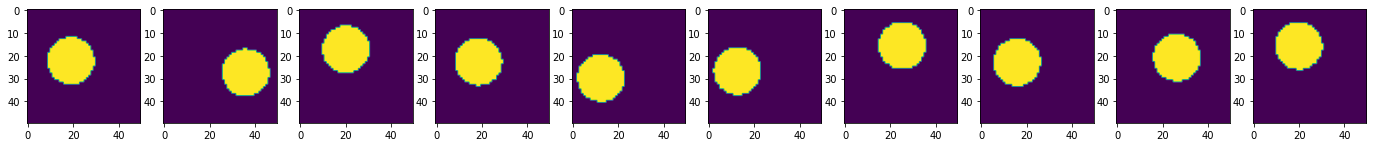

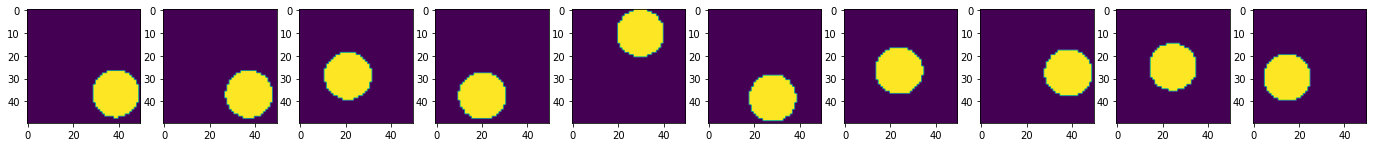

In [114]:
for i in range(0, len(cluster2_target)):   
    # plt.matshow(centroids[i])
    view_img(images=cluster2_target[i],row=1,col=10,size=24,numImg=10)

Evaluate our models

In [118]:
silhouette_avg_3 = silhouette_score(fieldCS, kmeans3.fit_predict(fieldCS))
silhouette_avg_2 = silhouette_score(fieldCS, kmeans2.fit_predict(fieldCS))

[silhouette_avg_3, silhouette_avg_2]

[0.1428550545356902, 0.19898593182518498]

Evaluate other number of clusters

Text(0.5, 1.0, 'Elbow Plot for MiniBatchKmeans')

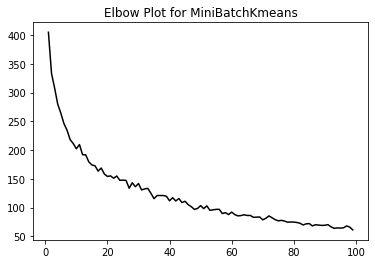

In [153]:
wcss = []
for i in range(1,100):
    minikmeans = MiniBatchKMeans(n_clusters = i, random_state = 420, batch_size=50, max_iter=100)
    wcss.append(minikmeans.fit(fieldCS).inertia_)

plt.plot(range(1,100), wcss,  c = "black")
plt.title("Elbow Plot for MiniBatchKmeans")

Maybe squares and circles are too similar to distinguish just from the field image?? 

Let's try this triangles and circles

In [127]:
fieldTri, targetTri, freqTri, shapeTri = readData("./TriangleDifFreq/", True)

Read 800 samples


In [128]:
fieldCT = np.concatenate((fieldCirc, fieldTri))
targetCT = np.concatenate((targetCirc, targetTri))
freqCT = np.concatenate((freqCirc, freqTri))
shapeCT = np.concatenate((shapeCirc, shapeTri))

In [154]:
fieldCT = fieldCT.reshape(len(fieldCT),-1)
fieldCT.shape

(1110, 576)

In [132]:
centroids3CT = kmeans3.fit(fieldCT).cluster_centers_.reshape(3,24,24)
centroids3CT.shape

(3, 24, 24)

Plot the centroids for the clusters

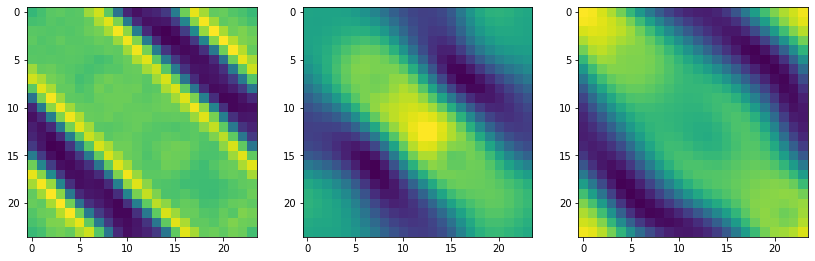

In [133]:
plt.figure(figsize = (14,14))
for index, img in enumerate(centroids3CT):
    plt.subplot(1,len(centroids3CT),index+1)
    plt.imshow(img)
    # plt.axis('off')

In [134]:
cluster3CT_img, cluster3CT_freq, cluster3CT_target, cluster3CT_shape = getClusters(kmeans3, fieldCT, freqCT, 
                                                                                   targetCT, shapeCT, True, False, 
                                                                                   True, True)

Cluster 0 has 725 images, frequency = [1000000000.0, 2000000000.0, 3000000000.0]
Cluster 1 has 154 images, frequency = [1000000000.0]
Cluster 2 has 231 images, frequency = [1000000000.0, 2000000000.0]
Cluster 0 has shape(s)['Circ', 'Triangle']
Cluster 1 has shape(s)['Triangle']
Cluster 2 has shape(s)['Circ', 'Triangle']


In [135]:
percent_summary(0, cluster3CT_freq, cluster3CT_shape, True)

Cluster: 0
      shape          freq  Count  Percentage
0      Circ  1.000000e+09     68    9.379310
1      Circ  2.000000e+09     57    7.862069
2      Circ  3.000000e+09     80   11.034483
3  Triangle  2.000000e+09    280   38.620690
4  Triangle  3.000000e+09    240   33.103448


In [136]:
percent_summary(1, cluster3CT_freq, cluster3CT_shape, True, True, True)

Cluster: 1
      shape          freq  Count  Percentage
0  Triangle  1.000000e+09    154       100.0
           freq  Count  Percentage
0  1.000000e+09    154       100.0
      shape  Count  Percentage
0  Triangle    154       100.0


In [137]:
percent_summary(2, cluster3CT_freq, cluster3CT_shape, True, True, True)

Cluster: 2
      shape          freq  Count  Percentage
0      Circ  1.000000e+09     62   26.839827
1      Circ  2.000000e+09     43   18.614719
2  Triangle  1.000000e+09    126   54.545455
           freq  Count  Percentage
0  1.000000e+09    188   81.385281
1  2.000000e+09     43   18.614719
      shape  Count  Percentage
0      Circ    105   45.454545
1  Triangle    126   54.545455


Cluster 1 only contains frequency 1e9. 

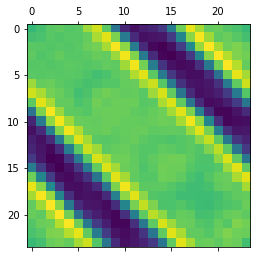

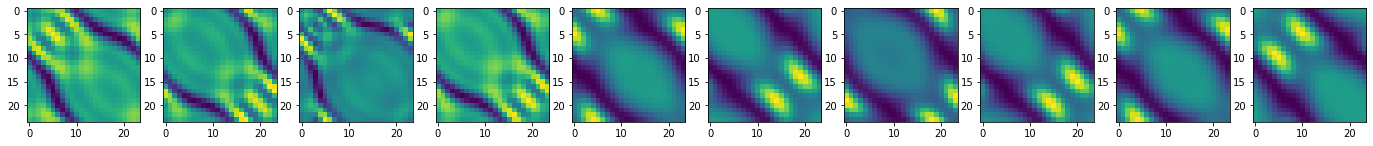

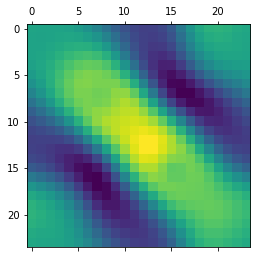

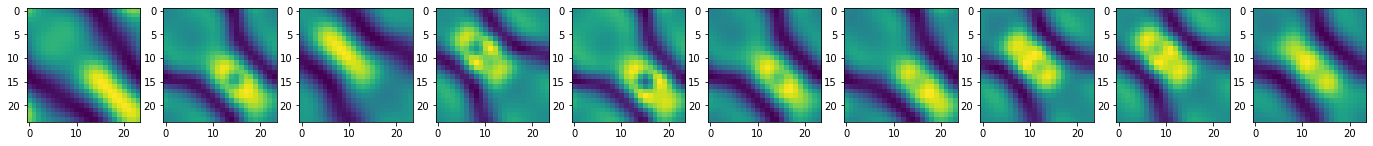

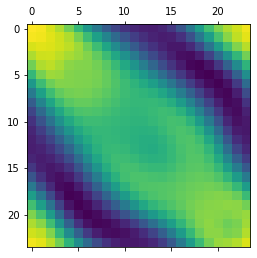

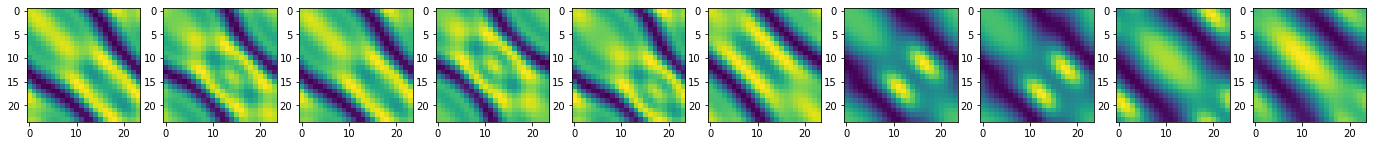

In [138]:
for i in range(0, len(cluster3CT_img)):   
    plt.matshow(centroids3CT[i])
    view_img(images = cluster3CT_img[i], row = 1, col = 10, size = 24, numImg = 10)

View target image

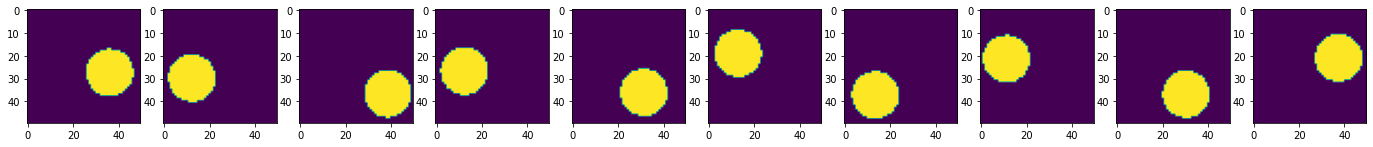

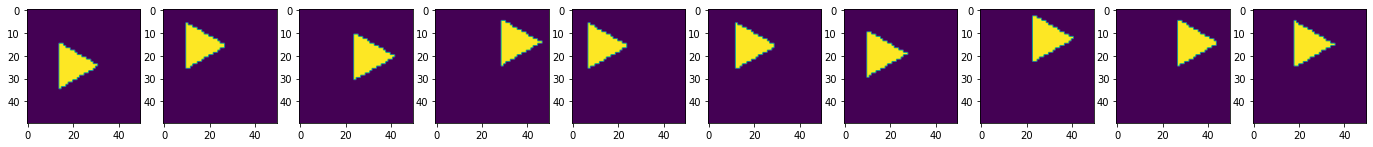

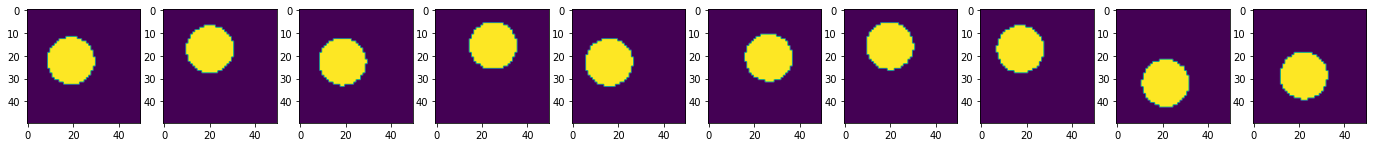

In [139]:
for i in range(0, len(cluster3CT_target)):   
    view_img(images=cluster3CT_target[i],row=1,col=10,size=24,numImg=10)

Try 2 clusters

In [141]:
centroids2CT = kmeans2.fit(fieldCT).cluster_centers_.reshape(2,24,24)
centroids2CT.shape

(2, 24, 24)

In [144]:
cluster2CT_img, cluster2CT_freq, cluster2CT_target, cluster2CT_shape = getClusters(kmeans2, fieldCT, freqCT, 
                                                                                   targetCT, shapeCT, True, False, 
                                                                                   True, True)

Cluster 0 has 806 images, frequency = [1000000000.0, 2000000000.0, 3000000000.0]
Cluster 1 has 304 images, frequency = [1000000000.0]
Cluster 0 has shape(s)['Circ', 'Triangle']
Cluster 1 has shape(s)['Circ', 'Triangle']


In [145]:
percent_summary(0, cluster2CT_freq, cluster2CT_shape, True, True, True)

Cluster: 0
      shape          freq  Count  Percentage
0      Circ  1.000000e+09    106   13.151365
1      Circ  2.000000e+09    100   12.406948
2      Circ  3.000000e+09     80    9.925558
3  Triangle  2.000000e+09    280   34.739454
4  Triangle  3.000000e+09    240   29.776675
           freq  Count  Percentage
0  1.000000e+09    106   13.151365
1  2.000000e+09    380   47.146402
2  3.000000e+09    320   39.702233
      shape  Count  Percentage
0      Circ    286   35.483871
1  Triangle    520   64.516129


In [146]:
percent_summary(1, cluster2CT_freq, cluster2CT_shape, True, True, True)

Cluster: 1
      shape          freq  Count  Percentage
0      Circ  1.000000e+09     24    7.894737
1  Triangle  1.000000e+09    280   92.105263
           freq  Count  Percentage
0  1.000000e+09    304       100.0
      shape  Count  Percentage
0      Circ     24    7.894737
1  Triangle    280   92.105263


Evaluate our models

In [147]:
silhouette_avg_3CT = silhouette_score(fieldCT, kmeans3.fit_predict(fieldCT))
silhouette_avg_2CT = silhouette_score(fieldCT, kmeans2.fit_predict(fieldCT))

[silhouette_avg_3CT,silhouette_avg_2CT]

[0.2933443684795425, 0.36566350256932006]

Evaluate other number of clusters

Text(0.5, 1.0, 'Elbow Plot for MiniBatchKmeans')

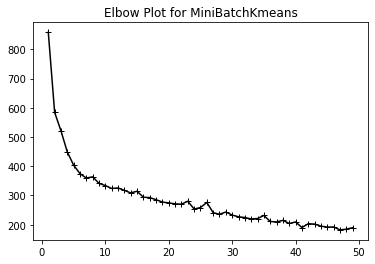

In [150]:
wcss_CT = []
for i in range(1,50):
    minikmeans = MiniBatchKMeans(n_clusters = i, random_state = 420, batch_size=50, max_iter=100)
    wcss_CT.append(minikmeans.fit(fieldCT).inertia_)

plt.plot(range(1,50), wcss_CT, marker = "+", c = "black")
plt.title("Elbow Plot for MiniBatchKmeans")